In [1]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
config = {
  "save_plots": False,
  "load_models": False,
}

In [3]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset

# download dataset using ogb pytorch geometric loader.
dataset = PygNodePropPredDataset(name="ogbn-arxiv")

data = dataset[0] # pyg graph object

print(data)

Data(edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['figure.figsize'] = [15, 12]
font = {'size': 32}
matplotlib.rc('font', **font)
alpha = 1

for ts in [2010,2013,2016,2020]:
  y = data.y[data.node_year <= ts].reshape(-1).detach().numpy()
  classes = np.unique(y)
  bins = np.append(classes, np.max(y)+1)

  hist = plt.hist(y, bins=bins, rwidth=0.8, color="#4363d8")
  print(hist)

  plt.xticks(None)
  plt.title(f"Class distribution - OGB Arxiv - Time step {ts}")
  plt.xlabel("Class")
  plt.ylabel("Number of node")
  plt.grid(True)

  plt.tight_layout()
  output_dir = "plots"
  os.makedirs(output_dir, exist_ok=True)
  plt.savefig(f"{output_dir}/arxiv-class-dist-{ts}.png")
  plt.close()
  # plt.show()

(array([  63.,   36.,  887.,  122.,  403.,  485.,  147.,   71.,  619.,
        650., 1134.,   83.,    9.,  197.,  137.,   52.,  200.,   25.,
          6.,    9.,  331.,   63.,  283.,  247.,  455.,   12.,   37.,
        143., 3122.,   33.,  399.,  182.,   33.,  116.,  935.,   24.,
        384.,  289.,  202.,  349.]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40]), <BarContainer object of 40 artists>)
(array([ 165.,  109., 1779.,  278.,  980., 1090.,  199.,  165., 1624.,
       1230., 2825.,  177.,   16.,  412.,  262.,  100.,  868.,   50.,
         78.,  336.,  704.,  143.,  574.,  529., 1900.,   28.,  696.,
        322., 7197.,   92.,  682.,  485.,   98.,  377., 2304.,   44.,
       1080.,  728.,  509.,  736.]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

graph is strongly connected component: False
graph is weakly connected component: True
graph has # weakly connected components: 1
graph has # isolated nodes: 0


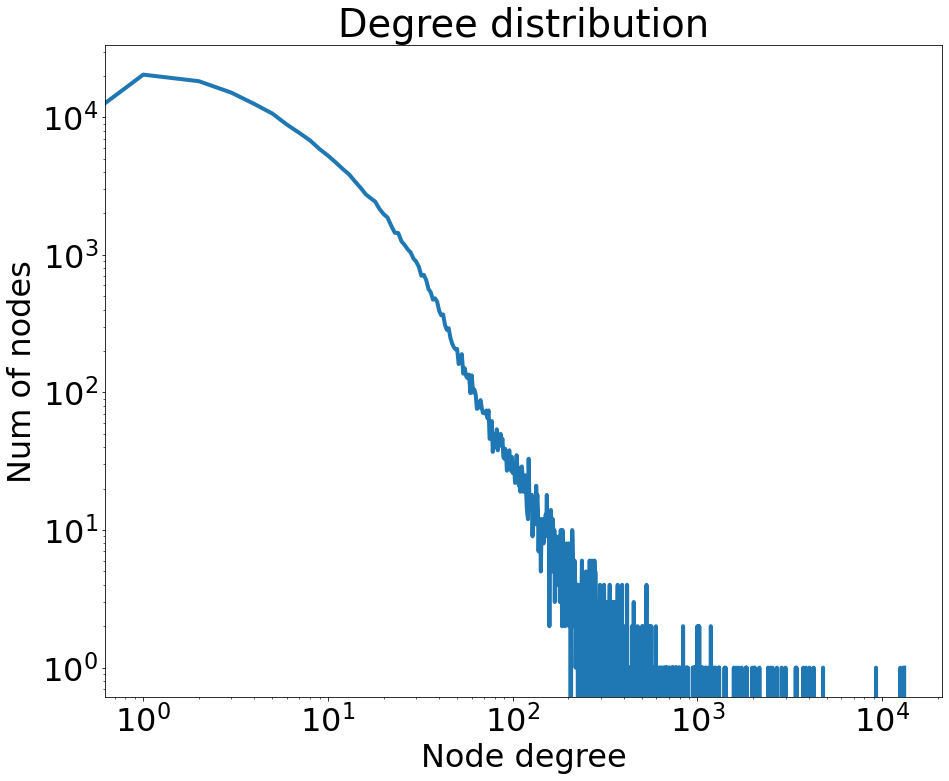

In [5]:
from lib import util

util.describe_graph(data, save_fig=config["save_plots"], log_scale=True)

## Split data set

year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
year: 2018
year: 2019
year: 2020
graph sizes
year: 2010, # nodes: 12974, # edges: 21090


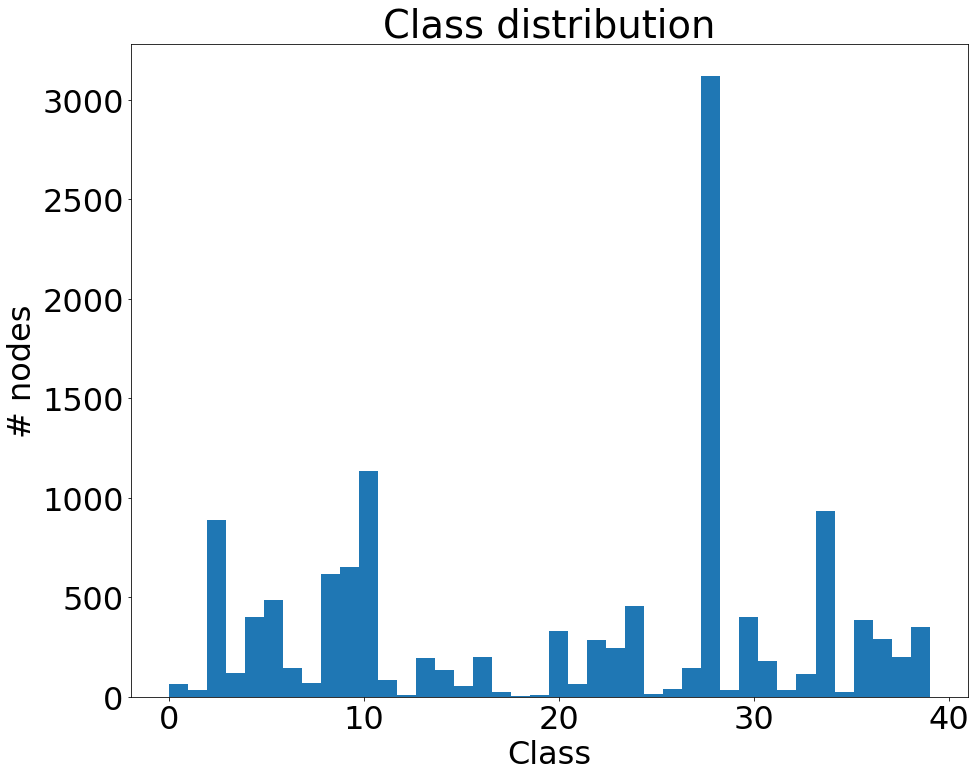

year: 2011, # nodes: 17401, # edges: 31661


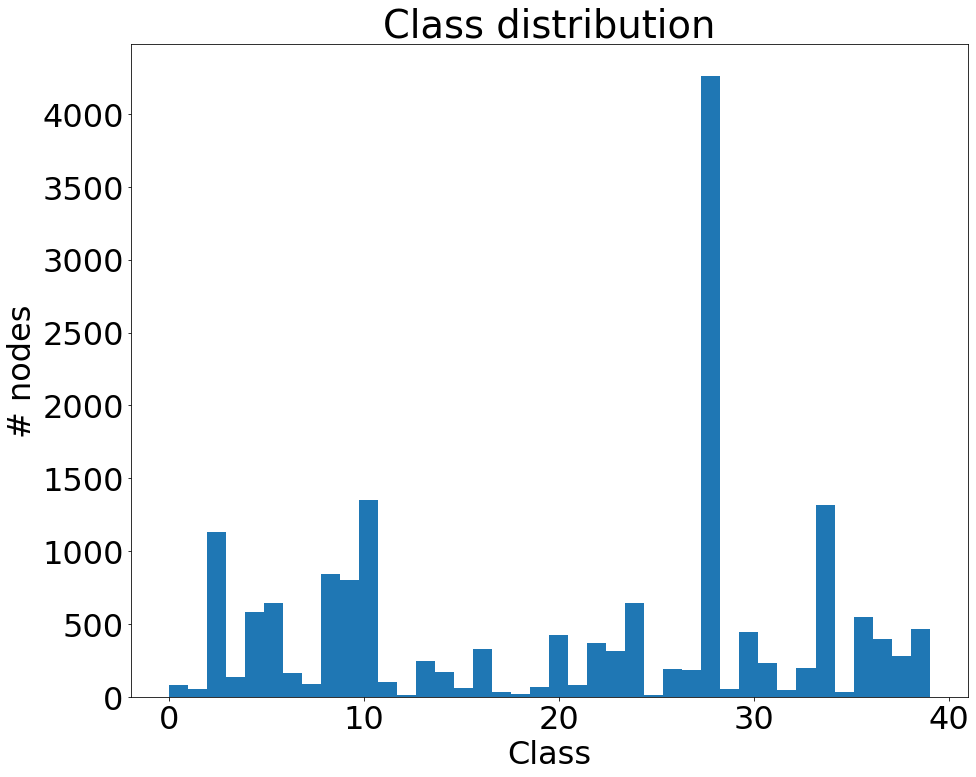

year: 2012, # nodes: 23836, # edges: 47335


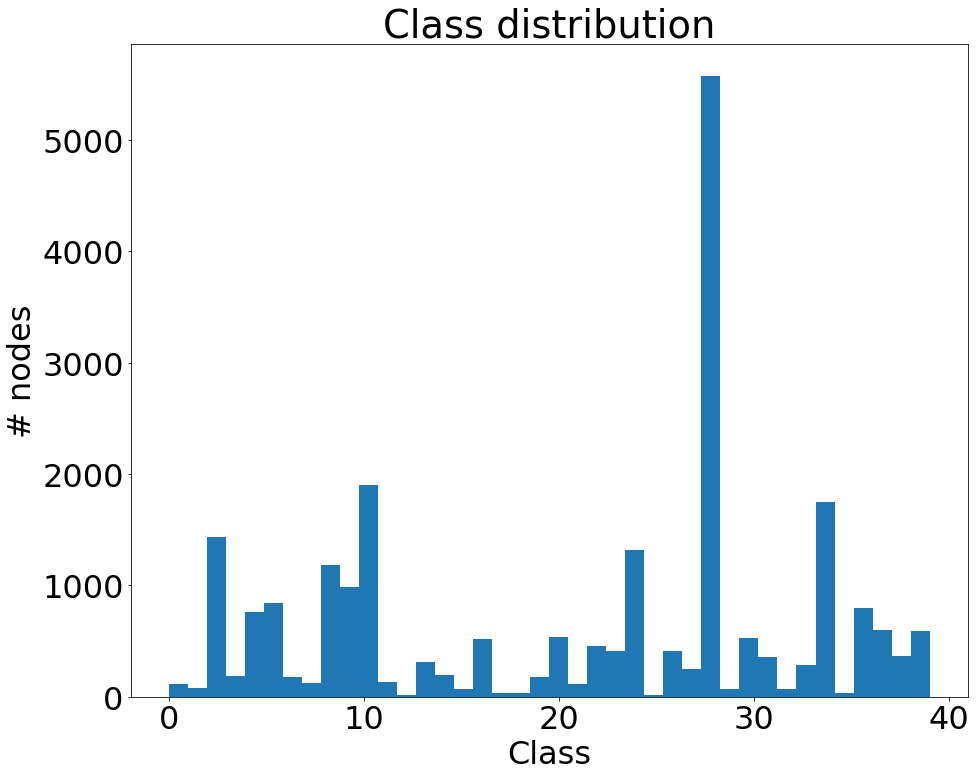

year: 2013, # nodes: 31971, # edges: 71669


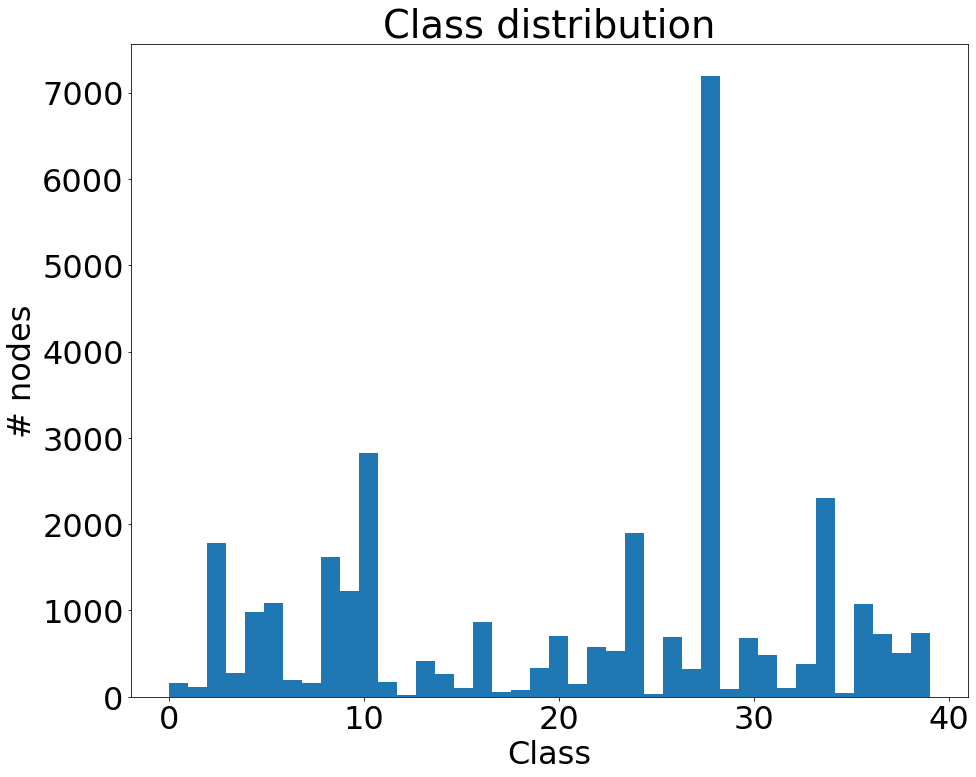

year: 2014, # nodes: 41125, # edges: 102316


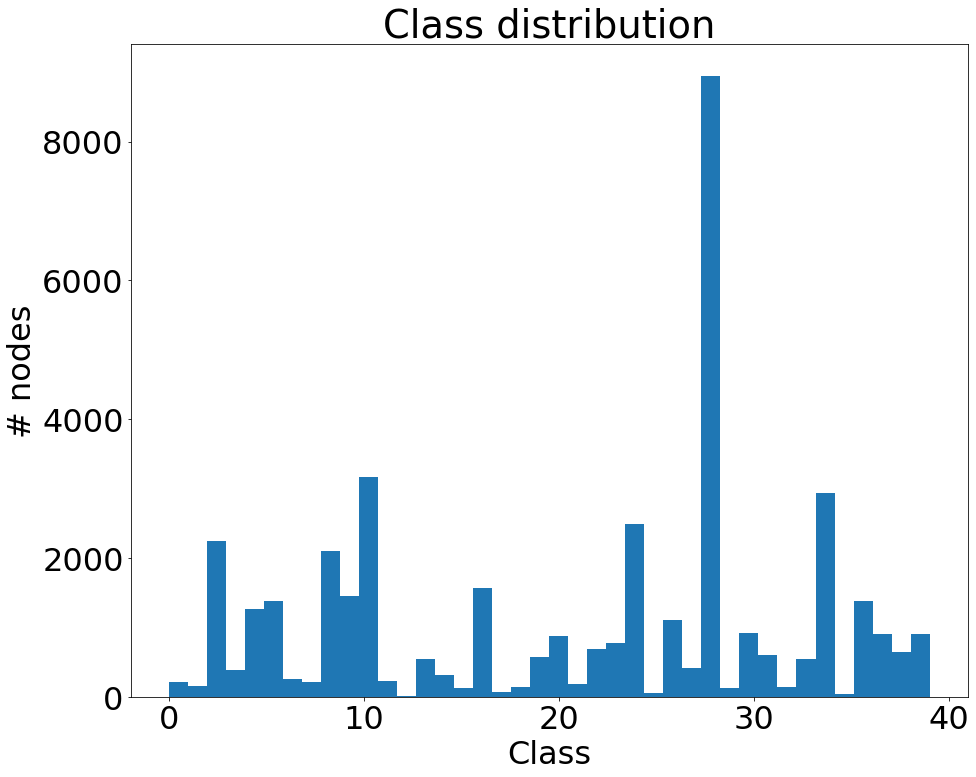

year: 2015, # nodes: 53160, # edges: 152226


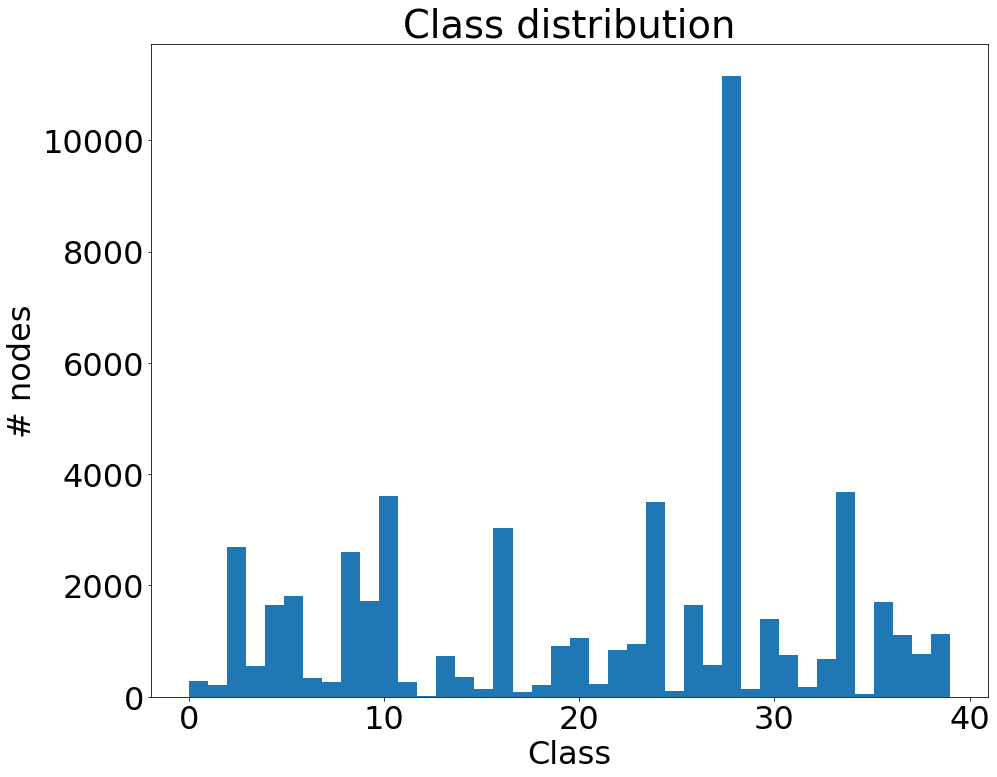

year: 2016, # nodes: 69499, # edges: 237163


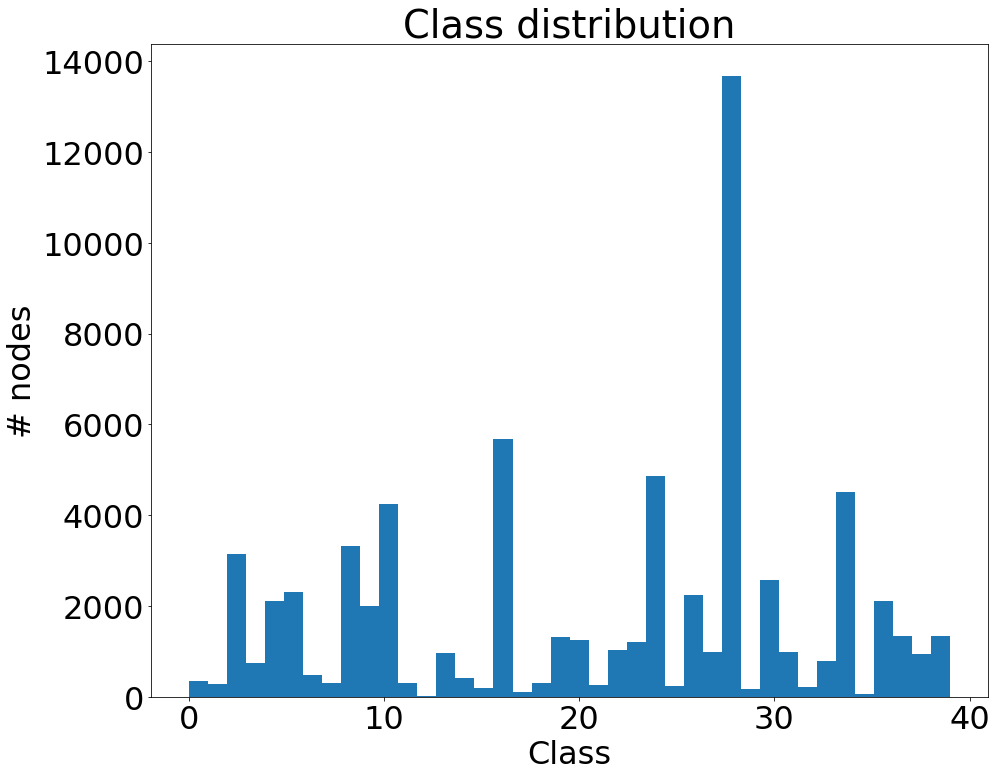

year: 2017, # nodes: 90941, # edges: 374839


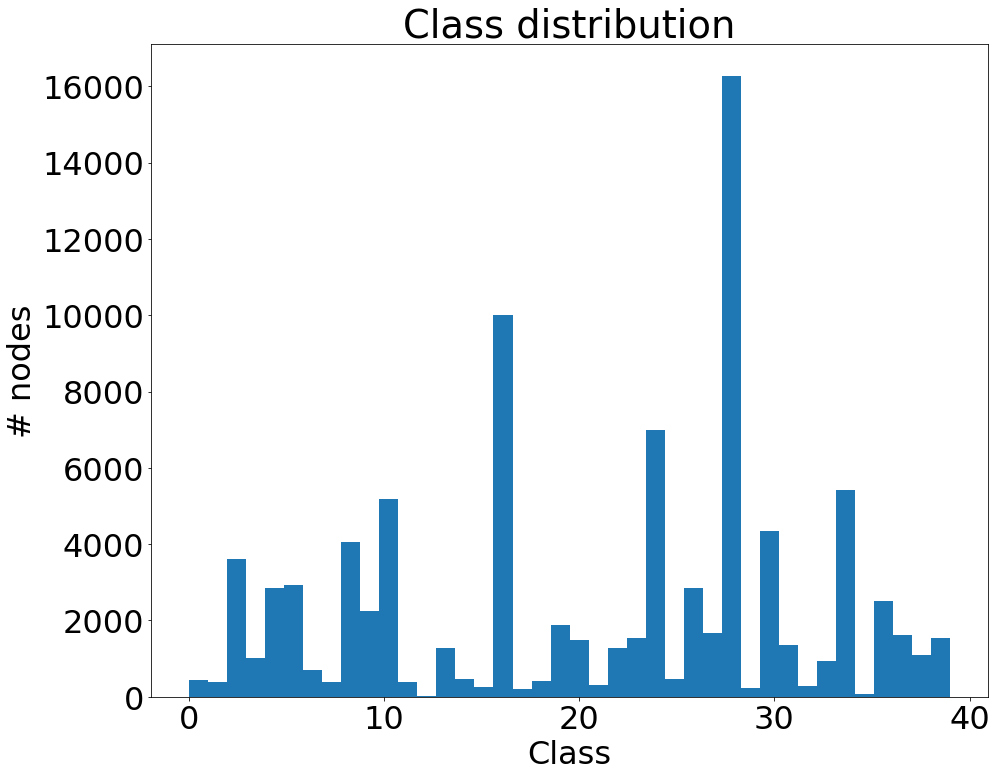

year: 2018, # nodes: 120740, # edges: 622466


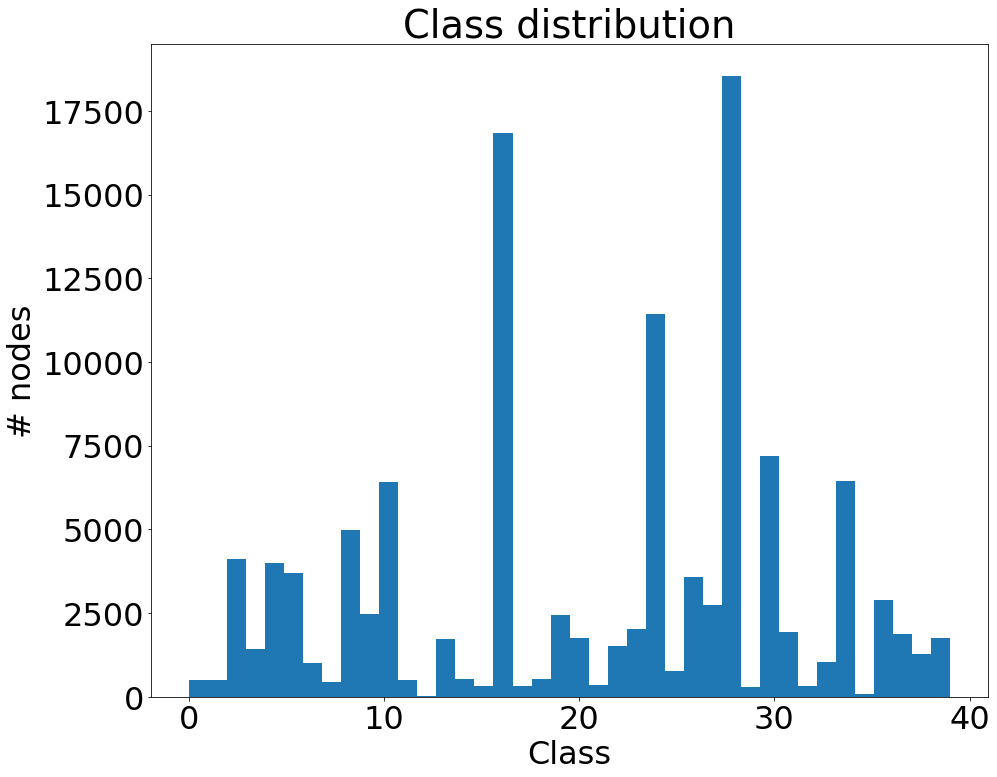

year: 2019, # nodes: 160451, # edges: 1061197


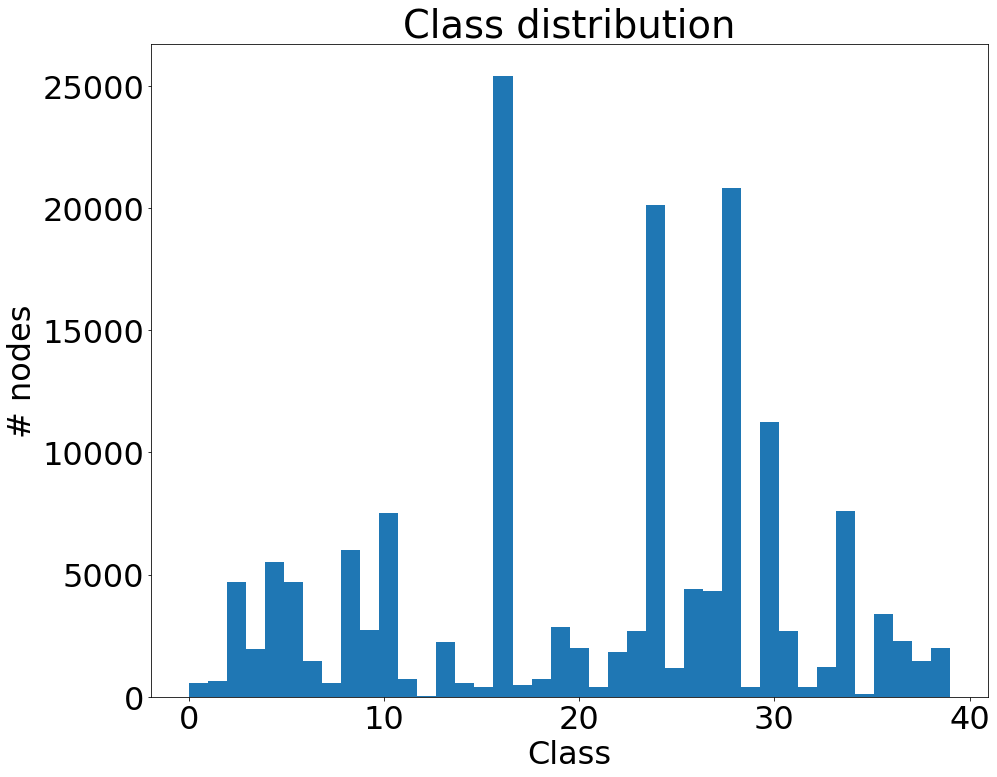

year: 2020, # nodes: 169343, # edges: 1166243


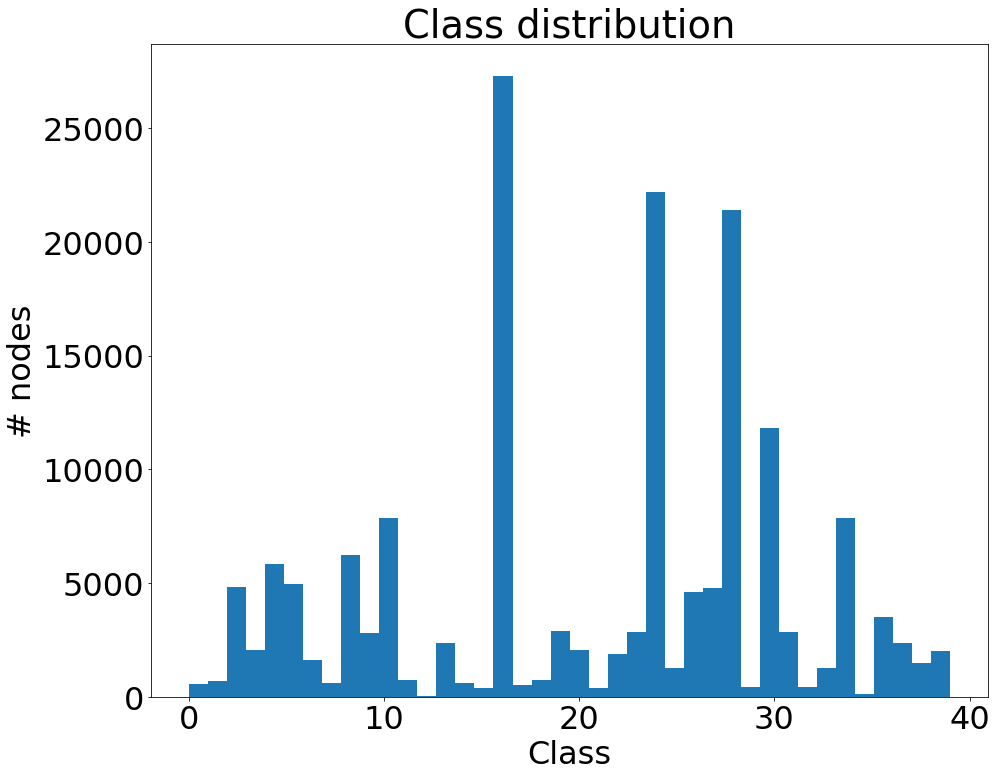

In [11]:
from lib.data import split_dataset, split

graphs = []

node_years = range(2010,2021)

for year in node_years:
  print("year: {}".format(year))
  indices = torch.nonzero(torch.where(data.node_year[:,0] <= year, 1, 0))[:,0].tolist()

  year_data = split(data, indices)

  # TODO: Retrieve test_indices only from current year
  train_data, calibration_indices, test_indices = split_dataset(year_data, test_frac=0.2, calibration_frac=0.2)
  graphs.append({
    "year": year,
    "data": year_data,
    "train_data": train_data,
    "calibration_indices": calibration_indices,
    "test_indices": test_indices,
  })

print("graph sizes")
for graph in graphs:
  print("year: {}, # nodes: {}, # edges: {}".format(graph["year"], graph["data"].x.shape[0], graph["data"].edge_index.shape[1]))
  plt.title("Class distribution")
  plt.hist(graph["data"].y.reshape(-1).detach().numpy(), dataset.num_classes)
  plt.xlabel("Class")
  plt.ylabel("# nodes")
  plt.show()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

for graph in graphs:
    graph["train_data"] = graph["train_data"].to(device)
    graph["data"] = graph["data"].to(device)

# data = data.to(device)

Device: cpu


# GraphSAGE model

In [8]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
    """
      sampling_size: number of neighbors to sample at each layer (list[int]).
    """
    super(GraphSAGE, self).__init__()

    self.num_layers = num_layers

    self.convs = torch.nn.ModuleList()
    self.bns = torch.nn.ModuleList()

    # input layer
    self.convs.append(SAGEConv(in_channels=input_dim, out_channels=hidden_dim, aggr="mean"))
    self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # hidden layers
    for _ in range(0, num_layers-1):
      self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim, aggr="mean"))
      self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # output layer
    self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=output_dim, aggr="mean"))

    self.softmax = torch.nn.LogSoftmax(dim=1)

    self.dropout = 0.1

    self.return_embeds = False

  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()

  def forward(self, x, adj_t):
    embedding = x
    for i, conv in enumerate(self.convs[:-1]):
      embedding = conv(x=embedding, edge_index=adj_t)
      embedding = self.bns[i](embedding)
      embedding = torch.nn.functional.relu(embedding)
      embedding = torch.nn.functional.dropout(embedding, p=self.dropout, training=self.training)
    
    # output layer
    embedding = self.convs[-1](x=embedding, edge_index=adj_t)

    node_class = self.softmax(embedding)

    if self.return_embeds:
      return node_class, embedding

    return node_class

  def train_model(self, data, optimizer, loss_fn):
    self.train()

    optimizer.zero_grad()
    
    out = self(data.x, data.edge_index)

    y_true = data.y.reshape(-1).detach()

    loss = loss_fn(out, y_true)

    loss.backward()
    optimizer.step()
  
  def predict(self, data):
    self.eval()
    
    if self.return_embeds:
        y_hat, embeddings = self(data.x, data.edge_index)
        return y_hat.clone().detach(), embeddings
        
    y_hat = self(data.x, data.edge_index)
    
    return y_hat.clone().detach()

  def set_return_embeds(self, return_embeds: bool):
    self.return_embeds = return_embeds


In [10]:
from lib.evaluation import get_binary_classification_performance

args = {
    "num_layers": 2,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 100,
}

model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

nll_loss = torch.nn.NLLLoss(weight=torch.tensor([0.2,1])) # negative log-likelihood
def custom_loss_fn(y_hat, y_true):
  known_class_indices = y_true != -1 # only look at nodes with known classes
  return nll_loss(y_hat[known_class_indices], y_true[known_class_indices])

loss_fn = custom_loss_fn

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn)
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

known_class_mask = y_true != -1
test_acc, test_f1_class_0, test_f1_class_1 = get_binary_classification_performance(y_hat[known_class_mask], y_true[known_class_mask])

print(f"Model found \n"
        f"Test acc: {100 * test_acc:.2f}%, "
        f"Test f1 (class 0): {100 * test_f1_class_0:.2f}%, "
        f"Test f1 (class 1): {100 * test_f1_class_1:.2f}%")

Epoch: 01


RuntimeError: weight tensor should be defined either for all 40 classes or no classes but got weight tensor of shape: [2]

# K-Means with graphsage trained on only first time step

In [ ]:
args = {
    "num_layers": 1,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 15,
    "batch_size": 128,
    "num_neighbors": [1],
    "max_stagnation": 15,
}

model = GraphSAGE(data.num_features, args["hidden_dim"], data.num_classes, args["num_layers"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

nll_loss = torch.nn.NLLLoss(weight=torch.tensor([0.2,1])) # negative log-likelihood
def custom_loss_fn(y_hat, y_true):
  known_class_indices = y_true != -1 # only look at nodes with known classes
  return nll_loss(y_hat[known_class_indices], y_true[known_class_indices])

loss_fn = custom_loss_fn

train_data = graphs[0]["train_data"]

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn)
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

known_class_mask = y_true != -1
test_acc, test_f1_class_0, test_f1_class_1 = get_binary_classification_performance(y_hat[known_class_mask], y_true[known_class_mask])

print(f"Model found \n"
        f"Test acc: {100 * test_acc:.2f}%, "
        f"Test f1 (class 0): {100 * test_f1_class_0:.2f}%, "
        f"Test f1 (class 1): {100 * test_f1_class_1:.2f}%")

Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Model found 
Test acc: 90.59%, Test f1 (class 0): 95.06%, Test f1 (class 1): 0.00%


In [ ]:
import itertools

matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['figure.figsize'] = [30, 12]
font = {'size': 32}
matplotlib.rc('font', **font)

markers = itertools.cycle(['o', 'v', '^', 'X', 's', 'p', 'D'])
colors = itertools.cycle(['#e6194B', '#f58231', '#ffe119', '#3cb44b', '#e303fc', '#4363d8'])

model.set_return_embeds(True)

sums_of_sums = []

for graph in graphs:
  _, embeds = model.predict(graph["data"])

  Sum_of_squared_distances = []
  K = range(1,10)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(embeds.detach().numpy())
    Sum_of_squared_distances.append(kmeans.inertia_)
  sums_of_sums.append(np.sum(Sum_of_squared_distances))
  ts = graph["ts"]
  plt.plot(K,Sum_of_squared_distances,label=f"Time step {ts}", marker=next(markers), color=next(colors), ls="-")
plt.xlabel("K") 
plt.ylabel("Sum of squared distances") 
plt.title("Elbow Method For Optimal K - Bitcoin Elliptic - train once")
# plt.legend(ncol=3)
plt.grid(True)

plt.tight_layout()
plt.savefig(f"plots/Elbow method for optimal K - Bitcoin Elliptic - Train once.png")
plt.close()
# # plt.show()

plt.plot(range(0,49),sums_of_sums,marker="o",color="#4363d8",ls="-", label="GraphSAGE embeddings")
plt.xlabel("Time step") 
plt.ylabel("Sum of squared distances") 
plt.grid(True)
plt.title("Score for K-means clustering - Bitcoin Elliptic - train once")
plt.savefig(f"plots/Score for K-means clustering - Bitcoin Elliptic - train once.png")
plt.close()

In [ ]:
num_nodes = []

for ts in range(1,50):
  nodes = data.y[data.time_steps == ts].reshape(-1).shape[0]
  num_nodes.append(nodes)

plt.plot(range(1,50),num_nodes,marker="o",color="#4363d8",ls="-", label="GraphSAGE embeddings")
plt.xlabel("Time step") 
plt.ylabel("New nodes") 
plt.grid(True)
plt.title("Number of nodes per time step - Bitcoin Elliptic")
plt.tight_layout()
plt.savefig(f"plots/Number of nodes per time step - Bitcoin Elliptic.png")
plt.close()
# plt.show()

# PCA

In [ ]:
from sklearn.decomposition import PCA

_, embeds = model.predict(data)

matplotlib.rcParams['lines.markersize'] = 14

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeds.detach().numpy())

plt.scatter(principalComponents[data.time_steps > 2,0], principalComponents[data.time_steps > 2,1], marker="o", c="#4363d8", label=f"Time step > 2", alpha=0.2)
plt.scatter(principalComponents[data.time_steps == 2,0], principalComponents[data.time_steps == 2,1], marker="v", c="#ffe119", label=f"Time step 2", alpha=0.4)
plt.scatter(principalComponents[data.time_steps == 1,0], principalComponents[data.time_steps == 1,1], marker="X", c="#e6194B", label=f"Time step 1", alpha=0.2)

plt.xscale("log")
plt.legend()
plt.grid(True)
plt.title("Principal Component Analysis of GraphSAGE embeddings - Bitcoin Elliptic")
plt.tight_layout()
plt.savefig(f"plots/Principal Component Analysis of GraphSAGE embeddings - Bitcoin Elliptic.png")
plt.close()